# 2023-07-26 Analysis and Plot Generation for Paper

This notebook will be analyzing the production results for the 2-qubit case.

In [1]:
from ast import literal_eval
import glob
from IPython.core.display import display, HTML
import itertools
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import re
from math import sqrt

import pygsti
from pygsti.baseobjs import Label as L
from pygsti.modelmembers.operations import LindbladErrorgen
from pygsti.tools import optools
from pygsti.protocols import CombinedExperimentDesign
from pygsti.protocols.gst import GateSetTomographyDesign

import scipy as sp
from scipy.optimize import curve_fit
#from sklearn.metrics import r2_score
import time

display(HTML('<style>.container { width:90% !important; }</style>'))

np.set_printoptions(precision = 6, linewidth = 200)

/tmp/ipykernel_2682243/2535083917.py:3: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
#plt.rcParams.update({
#    "text.usetex": True,
#    "font.family": "serif",
#    "font.serif": ["Computer Modern Roman"]
#})
#plt.rcParams['text.latex.preamble'] = r'\boldmath'

### Data loading ###

In [3]:
data_dir_0  = '../data/data_XYCPHASE_L1024_Full_Full/'
data_dir_1  = '../data/data_XYCPHASE_L1024_Full_Lite/'                      
data_dir_2  = '../data/data_XYCPHASE_L1024_Per_Germ_E033C30N1000_Lite/'     
data_dir_3  = '../data/data_XYCPHASE_L1024_Per_Germ_E033C30N20000_Lite/'    
data_dir_4  = '../data/data_XYCPHASE_L1024_Per_Germ_E25C4N1000_Lite/'       
data_dir_5  = '../data/data_XYCPHASE_L1024_Per_Germ_E25C4N20000_Lite/'
data_dir_6  = '../data/data_XYCPHASE_L1024_Per_Germ_E5C2N1000_Lite/'  
data_dir_7  = '../data/data_XYCPHASE_L1024_Per_Germ_E5C2N20000_Lite/' 
data_dir_8  = '../data/data_XYCPHASE_L1024_Per_Germ_Rand_03_Lite/'    
data_dir_9  = '../data/data_XYCPHASE_L1024_Per_Germ_Rand_06_Lite/'
data_dir_10 = '../data/data_XYCPHASE_L1024_Per_Germ_Rand_09_Lite/'
data_dir_11 = '../data/data_XYCPHASE_L1024_Per_Germ_Rand_12_Lite/'
data_dir_12 = '../data/data_XYCPHASE_L1024_Per_Germ_Rand_25_Lite/'
data_dir_13 = '../data/data_XYCPHASE_L1024_Per_Germ_Rand_50_Lite/'
# This has structure [{fpr key}, {gr key}].for_protocol(model_{model name}_datagen_{datagen index})
#combined_data = pygsti.io.load_results_from_dir(data_dir)

In [4]:
model_pkls = sorted(glob.glob(data_dir_0 + '*.pkl'))

print(model_pkls)

# Keys will be model_name, model_index
noise_models = {}
for mpkl in model_pkls:
    with open(mpkl, 'rb') as f:
        model = pickle.load(f)

    pklname = mpkl.split('/')[-1]
    entries = pklname.split('_')
    model_idx = int(entries[-1].split('.')[0])
    model_name = '_'.join(entries[:-1])
    #print(f'{mpkl}, {pklname}, {entries}, {model_idx}, {model_name}')

    noise_models[(model_name, model_idx)] = model

['../data/data_XYCPHASE_L1024_Full_Full/H_XYCPHASE_1e-2_normal_0.pkl', '../data/data_XYCPHASE_L1024_Full_Full/H_XYCPHASE_1e-2_normal_depol_0.pkl']


In [5]:
print(noise_models.keys())

dict_keys([('H_XYCPHASE_1e-2_normal', 0), ('H_XYCPHASE_1e-2_normal_depol', 0)])


In [6]:
from pygsti.modelpacks import smq2Q_XYCPHASE
target_model = smq2Q_XYCPHASE.target_model('static')

In [7]:
#load in the experiment designs:
edesign_0= GateSetTomographyDesign.from_dir(data_dir_0)
edesign_1= GateSetTomographyDesign.from_dir(data_dir_1)
edesign_2= GateSetTomographyDesign.from_dir(data_dir_2)
edesign_3= GateSetTomographyDesign.from_dir(data_dir_3)
edesign_4= GateSetTomographyDesign.from_dir(data_dir_4)
edesign_5= GateSetTomographyDesign.from_dir(data_dir_5)
edesign_6= GateSetTomographyDesign.from_dir(data_dir_6)
edesign_7= GateSetTomographyDesign.from_dir(data_dir_7)
edesign_8= GateSetTomographyDesign.from_dir(data_dir_8)
edesign_9= GateSetTomographyDesign.from_dir(data_dir_9)
edesign_10= GateSetTomographyDesign.from_dir(data_dir_10)
edesign_11= GateSetTomographyDesign.from_dir(data_dir_11)
edesign_12= GateSetTomographyDesign.from_dir(data_dir_12)
edesign_13= GateSetTomographyDesign.from_dir(data_dir_13)

edesign_dict= {('Full', 'Full'):edesign_0,
               ('Full', 'Lite'):edesign_1, ('PerGermE0.033C30.00N1000', 'Lite'):edesign_2, ('PerGermE0.033C30.00N20000', 'Lite'):edesign_3,
               ('PerGermE0.250C4.00N1000', 'Lite'):edesign_4, ('PerGermE0.250C4.00N20000', 'Lite'):edesign_5, ('PerGermE0.500C2.00N1000', 'Lite'):edesign_6, 
               ('PerGermE0.500C2.00N20000', 'Lite'):edesign_7, ('PerGermRand0.03-0','Lite'):edesign_8, ('PerGermRand0.06-0','Lite'):edesign_9,
               ('PerGermRand0.09-0','Lite'):edesign_10, ('PerGermRand0.12-0','Lite'):edesign_11, ('PerGermRand0.25-0','Lite'):edesign_12,
               ('PerGermRand0.50-0','Lite'):edesign_13}

comb_edesign=CombinedExperimentDesign(edesign_dict)

In [8]:
comb_edesign.keys()

dict_keys([('Full', 'Full'), ('Full', 'Lite'), ('PerGermE0.033C30.00N1000', 'Lite'), ('PerGermE0.033C30.00N20000', 'Lite'), ('PerGermE0.250C4.00N1000', 'Lite'), ('PerGermE0.250C4.00N20000', 'Lite'), ('PerGermE0.500C2.00N1000', 'Lite'), ('PerGermE0.500C2.00N20000', 'Lite'), ('PerGermRand0.03-0', 'Lite'), ('PerGermRand0.06-0', 'Lite'), ('PerGermRand0.09-0', 'Lite'), ('PerGermRand0.12-0', 'Lite'), ('PerGermRand0.25-0', 'Lite'), ('PerGermRand0.50-0', 'Lite')])

Curious about the number of circuits in each of the designs.

In [9]:
print('Num Ckts Full-Full: ', len(comb_edesign['Full', 'Full'].all_circuits_needing_data))
print('Num Ckts Full-Lite: ', len(comb_edesign['Full', 'Lite'].all_circuits_needing_data))
print('Num Ckts PerGermE.033C30N1000-Lite: ', len(comb_edesign['PerGermE0.033C30.00N1000', 'Lite'].all_circuits_needing_data))
print('Num Ckts PerGermE.033C30N20000-Lite: ', len(comb_edesign['PerGermE0.033C30.00N20000', 'Lite'].all_circuits_needing_data))
print('Num Ckts PerGermE0.250C4.00N1000-Lite: ', len(comb_edesign['PerGermE0.250C4.00N1000', 'Lite'].all_circuits_needing_data))
print('Num Ckts PerGermE0.250C4.00N20000-Lite: ', len(comb_edesign['PerGermE0.250C4.00N20000', 'Lite'].all_circuits_needing_data))
print('Num Ckts PerGermE0.500C2.00N1000-Lite: ', len(comb_edesign['PerGermE0.500C2.00N1000', 'Lite'].all_circuits_needing_data))
print('Num Ckts PerGermE0.500C2.00N20000-Lite: ', len(comb_edesign['PerGermE0.500C2.00N20000', 'Lite'].all_circuits_needing_data))
print('Num Ckts PerGermPowerRandom 50%-Lite: ', len(comb_edesign['PerGermRand0.50-0', 'Lite'].all_circuits_needing_data))
print('Num Ckts PerGermPowerRandom 25%-Lite: ', len(comb_edesign['PerGermRand0.25-0', 'Lite'].all_circuits_needing_data))
print('Num Ckts PerGermPowerRandom 12.5%-Lite: ', len(comb_edesign['PerGermRand0.12-0', 'Lite'].all_circuits_needing_data))
print('Num Ckts PerGermPowerRandom 9%-Lite: ', len(comb_edesign['PerGermRand0.09-0', 'Lite'].all_circuits_needing_data))
print('Num Ckts PerGermPowerRandom 6%-Lite: ', len(comb_edesign['PerGermRand0.06-0', 'Lite'].all_circuits_needing_data))
print('Num Ckts PerGermPowerRandom 3%-Lite: ', len(comb_edesign['PerGermRand0.03-0', 'Lite'].all_circuits_needing_data))

Num Ckts Full-Full:  104002
Num Ckts Full-Lite:  24042
Num Ckts PerGermE.033C30N1000-Lite:  10919
Num Ckts PerGermE.033C30N20000-Lite:  10725
Num Ckts PerGermE0.250C4.00N1000-Lite:  11003
Num Ckts PerGermE0.250C4.00N20000-Lite:  10758
Num Ckts PerGermE0.500C2.00N1000-Lite:  12022
Num Ckts PerGermE0.500C2.00N20000-Lite:  11464
Num Ckts PerGermPowerRandom 50%-Lite:  12480
Num Ckts PerGermPowerRandom 25%-Lite:  6644
Num Ckts PerGermPowerRandom 12.5%-Lite:  3683
Num Ckts PerGermPowerRandom 9%-Lite:  2816
Num Ckts PerGermPowerRandom 6%-Lite:  2206
Num Ckts PerGermPowerRandom 3%-Lite:  1405


In [10]:
#Load in the Pandas dataframes.
analysis_df_0 = pd.read_hdf('../data/dataframes/H_XYCPHASE_L1024_full_full.partial.h5')
analysis_df_1 = pd.read_hdf('../data/dataframes/H_XYCPHASE_L1024_full_lite.partial.h5')
analysis_df_2 = pd.read_hdf('../data/dataframes/H_XYCPHASE_L1024_pergermE033C30N1000_lite.partial.h5')
analysis_df_3 = pd.read_hdf('../data/dataframes/H_XYCPHASE_L1024_pergermE033C30N20000_lite.partial.h5')
analysis_df_4 = pd.read_hdf('../data/dataframes/H_XYCPHASE_L1024_pergermE25C4N1000_lite.partial.h5')
analysis_df_5 = pd.read_hdf('../data/dataframes/H_XYCPHASE_L1024_pergermE25C4N20000_lite.partial.h5')
analysis_df_6 = pd.read_hdf('../data/dataframes/H_XYCPHASE_L1024_pergermE5C2N1000_lite.partial.h5')
analysis_df_7 = pd.read_hdf('../data/dataframes/H_XYCPHASE_L1024_pergermE5C2N20000_lite.partial.h5')
analysis_df_8 = pd.read_hdf('../data/dataframes/H_XYCPHASE_L1024_pergermrand03_lite.partial.h5')
analysis_df_9 = pd.read_hdf('../data/dataframes/H_XYCPHASE_L1024_pergermrand06_lite.partial.h5')
analysis_df_10= pd.read_hdf('../data/dataframes/H_XYCPHASE_L1024_pergermrand09_lite.partial.h5')
analysis_df_11= pd.read_hdf('../data/dataframes/H_XYCPHASE_L1024_pergermrand12_lite.partial.h5')
analysis_df_12= pd.read_hdf('../data/dataframes/H_XYCPHASE_L1024_pergermrand25_lite.partial.h5')
analysis_df_13= pd.read_hdf('../data/dataframes/H_XYCPHASE_L1024_pergermrand50_lite.partial.h5')

In [11]:
#analysis_df_2

In [12]:
#combine the dataframes into a single data frame object:
df_list= [analysis_df_0,
          analysis_df_1,analysis_df_2, analysis_df_3, analysis_df_4, analysis_df_5, analysis_df_6, analysis_df_7,
          analysis_df_8, analysis_df_9, analysis_df_10,analysis_df_11,analysis_df_12,analysis_df_13]
combined_frame= pd.concat(df_list)

In [13]:
combined_frame['FPR'].unique()

array(['Full', 'E033C30N1000', 'E033C30N20000', 'E25C4N1000', 'E25C4N20000', 'E5C2N1000', 'E5C2N20000', '03', '06', '09', '12', '25', '50'], dtype=object)

In [14]:
combined_frame[combined_frame['FPR']=='12']['GR'].unique()

array(['Lite'], dtype=object)

In [15]:
combined_frame.head()

,FPR,FPR Index,GR,Model,Model Index,Datagen Index,Parameterization,Num GST Iterations,Gate,L,JTD,Eval MAE,Angle MAE,Diamond Dist
0,Full,0,Full,H_XYCPHASE_1e-2_normal_depol,0,2021,full TP,11,Gxpi2:1,"[1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]","[0.1273455406874759, 0.033103363506235745, 0.0...","[0.02250215771630421, 0.005233348084051209, 0....","[0.014798331970892947, 0.004108312923761455, 0...","[0.30804228805485345, 0.07812437861929832, 0.0..."
1,Full,0,Full,H_XYCPHASE_1e-2_normal_depol,0,2021,full TP,11,Gypi2:1,"[1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]","[0.1236604578026886, 0.030844111233046076, 0.0...","[0.028308739191612985, 0.005555677134840945, 0...","[0.008139101102065721, 0.0028778709990995117, ...","[0.2931841559480032, 0.07048321671814864, 0.01..."
2,Full,0,Full,H_XYCPHASE_1e-2_normal_depol,0,2021,full TP,11,Gxpi2:0,"[1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]","[0.10958556479355745, 0.022501388449559068, 0....","[0.01939305500241117, 0.004984571693955071, 0....","[0.008128590392285764, 0.0029314763686711445, ...","[0.3204545686751726, 0.04855113487384289, 0.01..."
3,Full,0,Full,H_XYCPHASE_1e-2_normal_depol,0,2021,full TP,11,Gypi2:0,"[1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]","[0.10978659058227763, 0.02561969731545439, 0.0...","[0.020005845700333008, 0.004418143003132432, 0...","[0.01639544256707414, 0.0019895538805266063, 0...","[0.30130008608997705, 0.055426150495471255, 0...."
4,Full,0,Full,H_XYCPHASE_1e-2_normal_depol,0,2021,full TP,11,Gcphase:0:1,"[1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]","[0.13974063133539372, 0.025256257897135537, 0....","[0.0541518862275497, 0.015894247614639794, 0.0...","[1.2006481797058322, 0.015327923728332624, 0.0...","[0.31282616064732993, 0.05379766292402308, 0.0..."


In [16]:
#analysis_df.loc[analysis_df['FPR']=='PerGermRand0.12']

### Calculate Average Diamond Norm Distances ###

In [17]:
#Take as input a dataframe object, FPR type, germ reduction type and parameterization and returned a list of the per iteration diamond distance
#averaged over the gate set for all models and dataset instantiations. This is is flattened with respect the the dataset and noisy model
#instantiations.
#Hardcode in the XYI gateset for now, can update this to pull in the gates from the target model later.
def average_gateset_diamond_distance_periter(dataframe, FPR_type, GR_type, parameterization, split_depol=False):
    """
    if split_depol is true then we separately out the coherent-only and coherent+depolarization model types.
    """    
    #Extract all of the rows from the dataframe object corresponding to the selected FPR_type, GR_type and parameterization.
    extracted_rows= dataframe[(dataframe['FPR']==FPR_type) & (dataframe['GR']==GR_type) & (dataframe['Parameterization']==parameterization)]
    #This returns a dataframe with just the desired rows.
    #Set a list of gate labels.
    gate_labels= ['Gxpi2:1', 'Gypi2:1', 'Gxpi2:0', 'Gypi2:0', 'Gcphase:0:1']
    #Now, for each (FPR Index, Model, Model Index, Datagen index) tuple we need to average the diamond distance over the
    #Get unique fpr indices, only relevant for random FPR where we may have multiple random instantiations.
    unique_fpr_indices = extracted_rows['FPR Index'].unique()
    #unique model labels
    unique_model_labels= extracted_rows['Model'].unique()
    #unique model instantiation indexes
    unique_model_indices= extracted_rows['Model Index'].unique()
    #finally, unique data generation instantiations
    unique_datagen_indices= extracted_rows['Datagen Index'].unique()
    
    
    if split_depol==False:
        #just stick the averages into a single list
        avg_gateset_ddists=[]
    else:
        #otherwise we need a nested list for the two model types.
        avg_gateset_ddists1=[]
        avg_gateset_ddists2=[] 
    
    #Now iterate through all of the combinations of these and average over the gates:
    for fpr, mdl_lbl, mdl_idx, datagen_idx in itertools.product(unique_fpr_indices, unique_model_labels, unique_model_indices, unique_datagen_indices):
        #pull out the rows corresponding to these labels/indices:
        rows_to_average= extracted_rows[(extracted_rows['FPR Index']==fpr) & (extracted_rows['Model']==mdl_lbl) &
                                        (extracted_rows['Model Index']==mdl_idx) & (extracted_rows['Datagen Index']== datagen_idx)]
        #pull out the diamond distances for these rows and turn them into a numpyarray, on second though I shouldn't actually need
        #to index by gate since that should be the only free parameter left. A quick test confirms this.
        if rows_to_average.empty:
            continue
        per_gate_ddists= rows_to_average['Diamond Dist']
        try:
            avg_gate_ddist= np.asarray(per_gate_ddists.iloc[0])
        except IndexError as error:
            print(error, per_gate_ddists, rows_to_average, sep = '\n')
            print(f'fpr = {fpr}, mdl_lbl = {mdl_lbl}, mdl_idx = {mdl_idx}, dg_idx = {datagen_idx}')
        for i in range(1,len(per_gate_ddists)):
            avg_gate_ddist += np.asarray(per_gate_ddists.iloc[i])
        avg_gate_ddist= avg_gate_ddist/len(per_gate_ddists)
        #append this to a running list of average diamond distances
        #different behavior here depending on whether we are separating out the two model types.
        
        if split_depol==False:
            avg_gateset_ddists.append(avg_gate_ddist)
        else:
            if 'depol' in mdl_lbl:
                avg_gateset_ddists2.append(avg_gate_ddist)
            else: 
                avg_gateset_ddists1.append(avg_gate_ddist)
    if split_depol==False:
        return avg_gateset_ddists
    else:
        return (avg_gateset_ddists1, avg_gateset_ddists2)

In [18]:
avg_gateset_ddists_full_lite_TP = average_gateset_diamond_distance_periter(combined_frame, 'Full', 'Full', 'full TP', split_depol=True)
print(len(avg_gateset_ddists_full_lite_TP[0]), avg_gateset_ddists_full_lite_TP)

1 ([array([2.756680e-01, 6.521764e-02, 1.185545e-02, 4.866476e-03, 3.122650e-03, 1.916845e-03, 1.243022e-03, 6.745869e-04, 3.846739e-04, 2.117873e-04, 1.157547e-04])], [array([0.307161, 0.061277, 0.014178, 0.005774, 0.00354 , 0.00245 , 0.001641, 0.00104 , 0.000721, 0.000551, 0.000481])])


In [19]:
avg_gateset_ddists_full_full_TP_coher, avg_gateset_ddists_full_full_TP_incoher = average_gateset_diamond_distance_periter(combined_frame, 'Full', 'Full', 'full TP', split_depol=True)
avg_gateset_ddists_full_lite_TP_coher, avg_gateset_ddists_full_lite_TP_incoher = average_gateset_diamond_distance_periter(combined_frame, 'Full', 'Lite', 'full TP', split_depol=True)
avg_gateset_ddists_pergermE033C30N1000_lite_TP_coher, avg_gateset_ddists_pergermE033C30N1000_lite_TP_incoher = average_gateset_diamond_distance_periter(combined_frame, 'E033C30N1000', 'Lite', 'full TP', split_depol=True)
avg_gateset_ddists_pergermE033C30N20000_lite_TP_coher, avg_gateset_ddists_pergermE033C30N20000_lite_TP_incoher = average_gateset_diamond_distance_periter(combined_frame, 'E033C30N20000', 'Lite', 'full TP', split_depol=True)
avg_gateset_ddists_pergermE25C4N1000_lite_TP_coher, avg_gateset_ddists_pergermE25C4N1000_lite_TP_incoher = average_gateset_diamond_distance_periter(combined_frame, 'E25C4N1000', 'Lite', 'full TP', split_depol=True)
avg_gateset_ddists_pergermE25C4N20000_lite_TP_coher, avg_gateset_ddists_pergermE25C4N20000_lite_TP_incoher = average_gateset_diamond_distance_periter(combined_frame, 'E25C4N20000', 'Lite', 'full TP', split_depol=True)
avg_gateset_ddists_pergermE5C2N1000_lite_TP_coher, avg_gateset_ddists_pergermE5C2N1000_lite_TP_incoher = average_gateset_diamond_distance_periter(combined_frame, 'E5C2N1000', 'Lite', 'full TP', split_depol=True)
avg_gateset_ddists_pergermE5C2N20000_lite_TP_coher, avg_gateset_ddists_pergermE5C2N20000_lite_TP_incoher = average_gateset_diamond_distance_periter(combined_frame, 'E5C2N20000', 'Lite', 'full TP', split_depol=True)
avg_gateset_ddists_pergermrand05_lite_TP_coher, avg_gateset_ddists_pergermrand05_lite_TP_incoher = average_gateset_diamond_distance_periter(combined_frame, '50', 'Lite', 'full TP', split_depol=True)
avg_gateset_ddists_pergermrand025_lite_TP_coher, avg_gateset_ddists_pergermrand025_lite_TP_incoher = average_gateset_diamond_distance_periter(combined_frame, '25', 'Lite', 'full TP', split_depol=True)
avg_gateset_ddists_pergermrand012_lite_TP_coher, avg_gateset_ddists_pergermrand012_lite_TP_incoher = average_gateset_diamond_distance_periter(combined_frame, '12', 'Lite', 'full TP', split_depol=True)
avg_gateset_ddists_pergermrand009_lite_TP_coher, avg_gateset_ddists_pergermrand009_lite_TP_incoher = average_gateset_diamond_distance_periter(combined_frame, '09', 'Lite', 'full TP', split_depol=True)
avg_gateset_ddists_pergermrand006_lite_TP_coher, avg_gateset_ddists_pergermrand006_lite_TP_incoher = average_gateset_diamond_distance_periter(combined_frame, '06', 'Lite', 'full TP', split_depol=True)
avg_gateset_ddists_pergermrand003_lite_TP_coher, avg_gateset_ddists_pergermrand003_lite_TP_incoher = average_gateset_diamond_distance_periter(combined_frame, '03', 'Lite', 'full TP', split_depol=True)

In [20]:
#print(avg_gateset_ddists_full_full_TP_coher)

In [21]:
def plot_ensemble_ddists(ddist_lists, L_dicts, labels, styles, title, ylabel, filename, figure_size=None, leg_loc=None, ncol=None, leg_fontsize=14):
    
    if figure_size is not None:
        plt.figure(figsize=figure_size)
    
    for ddist_list, L_dict, mdl_styles, mdl_labels in zip(ddist_lists, L_dicts, styles, labels):
        lengths = list(L_dict.keys())
        #print(lengths)
        #print(ddist_list)
        #I don't actually use the index below, not sure why I'm trying to debug this...
#         try:
#             idx = ddist_lists.index(ddist_list)
#         except ValueError as err:
#             print('Encountered Value Error')
#             print(err)
#             #continue
#             print(ddist_list)        
        for i,ys in enumerate(ddist_list):
            #print(i)
            #print(ys)
            ys = np.array(ys)
            if i == 0:
                plt.plot(lengths, ys, mdl_styles, label=mdl_labels)
            else:
                plt.plot(lengths, ys, mdl_styles)

    fit_line = [(1/sqrt(1000))/L for L in lengths]
    
    plt.plot(lengths, fit_line, 'k--', label=r'Heisenberg scaling')

    axes = plt.gca()
    axes.set_xscale('log')
    axes.set_xticks(lengths)
    axes.set_xticklabels([r'$1$', r'$2$', r'$4$', r'$8$', r'$16$', r'$32$', r'$64$',r'$128$', r'$256$', r'$512$', r'$1024$' ], fontsize= 22, fontweight='bold')
    axes.minorticks_off()
    axes.set_yscale('log')
    axes.set_ylim([.25e-4, 1])

    plt.grid()
    #plt.legend(ncol=2, loc='lower left')
    if leg_loc is None:
        if ncol is None:
            plt.legend(loc='upper left', ncol=1, fontsize=leg_fontsize)
        else:
            plt.legend(loc='upper left', ncol=ncol, fontsize=leg_fontsize)
    else:
        if ncol is None:
            plt.legend(loc=leg_loc, ncol=1, fontsize=leg_fontsize)
        else:
            plt.legend(loc=leg_loc, ncol=ncol, fontsize=leg_fontsize)
    plt.title(title, fontsize=16)
    plt.xlabel(r'$L$ (Max Circuit Depth)', fontsize=24)
    plt.xlim([0.9, lengths[-1]])
    plt.ylabel(ylabel, fontsize=24)
    plt.yticks(fontsize=22)
    plt.tight_layout()
    plt.savefig(filename, facecolor='white', dpi=128)
    plt.show()

In [22]:
# #Define this for compatibility with Stefan's code for the plot generation.
# def get_shot_counts_by_L(edesign, num_shots=1e4):
#     circs = edesign.all_circuits_needing_data
#     L_shots = {}
    
#     for (L, _), plaq in circs.iter_plaquettes():
        
#         print('L: ', L)
        
#         #if L=1 we need to add in some additional circuits from LGST
#         if L==1 and (circs._additional_circuits is not None) and circs._additional_circuits and L_shots.get(L, 0) == 0:
#             print('Running L=1 Case')
#             plaq_shots = len(list(plaq.circuits)) * num_shots + len(list(circs._additional_circuits)) * num_shots
            
#             #print('L=1 case: ', plaq_shots)
            
#         else:
#             plaq_shots = len(list(plaq.circuits)) * num_shots
#             print('L!=1 case: ', plaq_shots)
                
#         L_shots[L] = L_shots.get(L, 0) + plaq_shots
    
#     # TODO: Check we actually use all subsets of L
#     cumul_shots = 0
#     cumul_L_shots = {}
#     for L, shots in L_shots.items():
#         cumul_shots += shots
#         cumul_L_shots[L] = cumul_shots
#     return cumul_L_shots

In [23]:
def get_shot_counts_by_L(edesign, num_shots=1e4):
    
    ckt_lists= edesign.circuit_lists
    
    #Take the pairwise set differences of each of these circuit lists to get the unique circuits per iteration:
    unique_ckts_by_iter= [ckt_lists[0]]
    
    for i in range(1,len(ckt_lists)):
        unique_ckts_by_iter.append(list(set(ckt_lists[i])-set(ckt_lists[i-1])))
                                   
    #Now put together the dictionary for L vs shots:
    total_shots = 0
    cumul_L_shots = {}
    for i in range(len(ckt_lists)):
        total_shots += len(unique_ckts_by_iter[i])*num_shots
        cumul_L_shots[2**i]= total_shots
                                   
    return cumul_L_shots

In [24]:
#list(comb_edesign['Full', 'Lite'].circuit_lists[0])
# total_num_ckts=0
# for ckt_list in comb_edesign['Full', 'Lite'].circuit_lists:
#     total_num_ckts+=len(ckt_list)
# print(total_num_ckts)
# print(len(comb_edesign['Full', 'Lite'].circuit_lists[-1]))

In [25]:
fl_shots = get_shot_counts_by_L(comb_edesign['Full','Lite'], num_shots=1)
print(fl_shots)

{1: 731, 2: 1509, 4: 3175, 8: 5779, 16: 8388, 32: 10997, 64: 13606, 128: 16215, 256: 18824, 512: 21433, 1024: 24042}


In [26]:
ff_shots = get_shot_counts_by_L(comb_edesign['Full','Full'], num_shots=1)
print(ff_shots)

{1: 731, 2: 2348, 4: 8625, 8: 20443, 16: 32380, 32: 44317, 64: 56254, 128: 68191, 256: 80128, 512: 92065, 1024: 104002}


In [27]:
comb_edesign['Full', 'Lite'].all_circuits_needing_data._additional_circuits

()

### Full GR Full FPR Baseline Avg Diamond Distance Plot

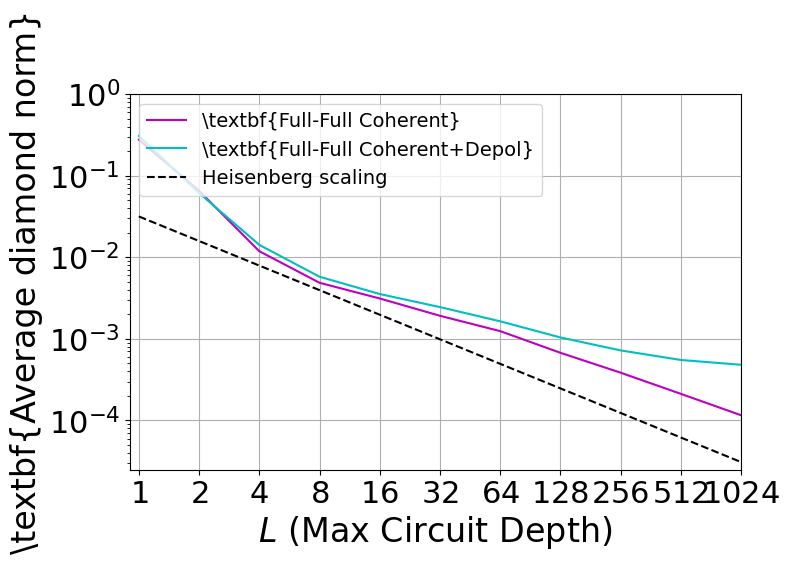

In [28]:
plot_ensemble_ddists([avg_gateset_ddists_full_full_TP_coher, avg_gateset_ddists_full_full_TP_incoher], [ff_shots, ff_shots], 
                     [r'Full-Full Coherent', r'Full-Full Coherent+Depol'], [ 'm-', 'c-'], '', r'Average diamond norm', 
                     './figure_output/avg_ddist_full_full_TP_coher_incoher.png', figure_size= (8,5))

### Lite GR Full FPR Baseline Avg Diamond Distance Plot

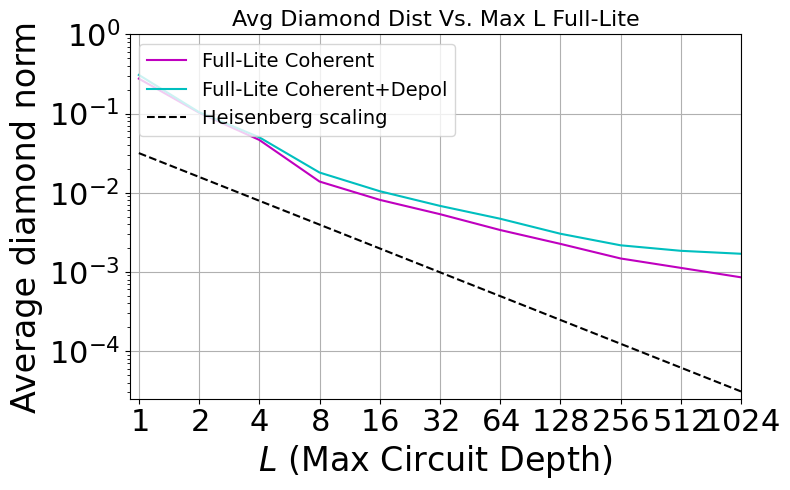

In [29]:
plot_ensemble_ddists([avg_gateset_ddists_full_lite_TP_coher, avg_gateset_ddists_full_lite_TP_incoher], [fl_shots, fl_shots], 
                     ['Full-Lite Coherent', 'Full-Lite Coherent+Depol'], [ 'm-', 'c-'], 'Avg Diamond Dist Vs. Max L Full-Lite', 'Average diamond norm', 
                     './figure_output/avg_ddist_full_lite_TP_coher_incoher.png', figure_size= (8,5))

### Lite GR and PerGerm E.033C30N1000 FPR Avg Diamond Distance Plot

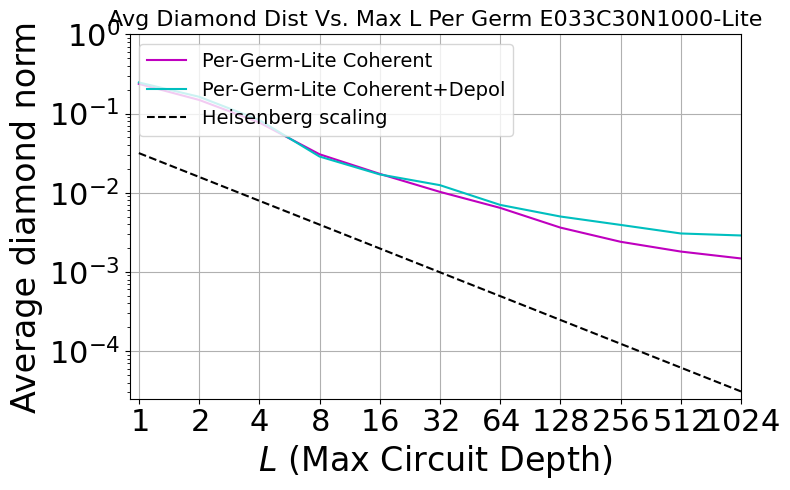

In [30]:
plot_ensemble_ddists([avg_gateset_ddists_pergermE033C30N1000_lite_TP_coher, avg_gateset_ddists_pergermE033C30N1000_lite_TP_incoher], [fl_shots, fl_shots], 
                     ['Per-Germ-Lite Coherent', 'Per-Germ-Lite Coherent+Depol'], [ 'm-', 'c-'], 'Avg Diamond Dist Vs. Max L Per Germ E033C30N1000-Lite', 'Average diamond norm',
                     './figure_output/avg_ddist_pergermE033C30N1000_lite_TP_coher_incoher.png', figure_size=(8,5))

### Lite GR and Per-Germ E.033C30N20000 FPR Avg Diamond Distance Plot

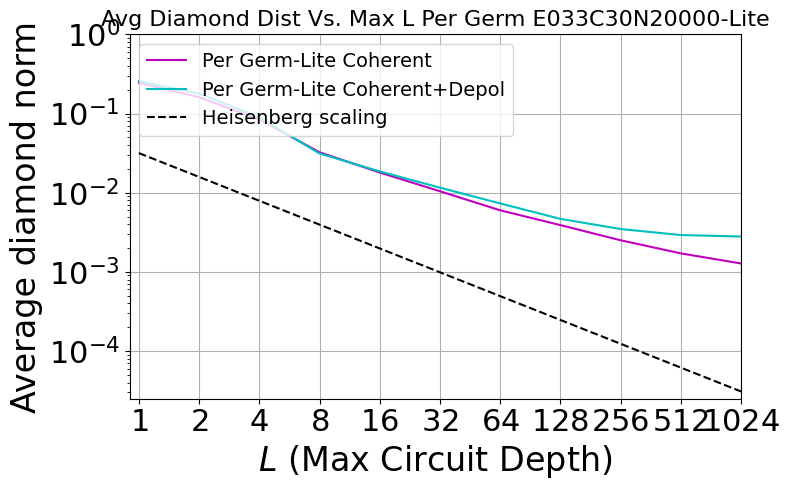

In [31]:
plot_ensemble_ddists([avg_gateset_ddists_pergermE033C30N20000_lite_TP_coher, avg_gateset_ddists_pergermE033C30N20000_lite_TP_incoher], [fl_shots, fl_shots], 
                     ['Per Germ-Lite Coherent', 'Per Germ-Lite Coherent+Depol'], [ 'm-', 'c-'], 'Avg Diamond Dist Vs. Max L Per Germ E033C30N20000-Lite', 'Average diamond norm',
                     './figure_output/avg_ddist_pergermE033C30N20000_lite_TP_coher_incoher.png', figure_size=(8,5))

### Lite GR and Per-Germ E25C4N1000 FPR Avg Diamond Distance Plot

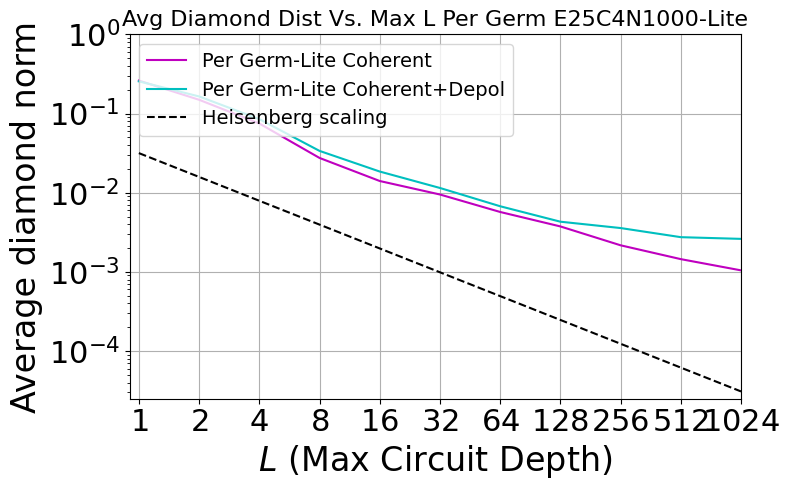

In [32]:
plot_ensemble_ddists([avg_gateset_ddists_pergermE25C4N1000_lite_TP_coher, avg_gateset_ddists_pergermE25C4N1000_lite_TP_incoher], [fl_shots, fl_shots], 
                     ['Per Germ-Lite Coherent', 'Per Germ-Lite Coherent+Depol'], [ 'm-', 'c-'], 'Avg Diamond Dist Vs. Max L Per Germ E25C4N1000-Lite', 'Average diamond norm',
                     './figure_output/avg_ddist_pergermE25C4N1000_lite_TP_coher_incoher.png', figure_size=(8,5))

### Lite GR and Per-Germ E25C4N20000 FPR Avg Diamond Distance Plot

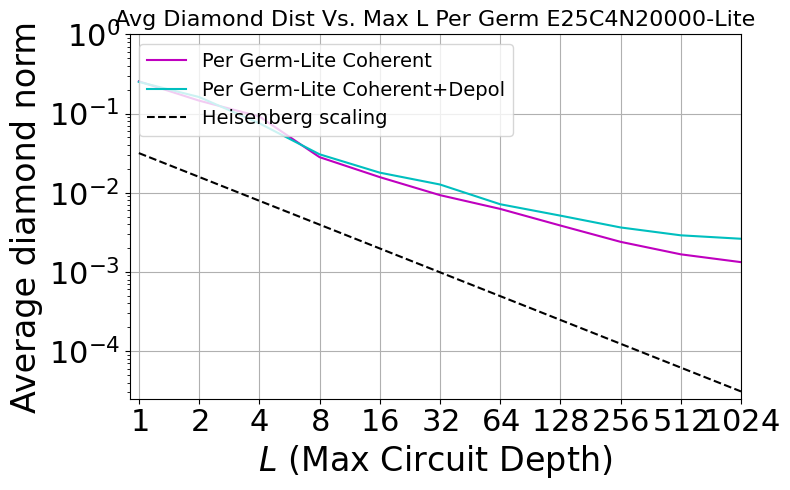

In [33]:
plot_ensemble_ddists([avg_gateset_ddists_pergermE25C4N20000_lite_TP_coher, avg_gateset_ddists_pergermE25C4N20000_lite_TP_incoher], [fl_shots, fl_shots], 
                     ['Per Germ-Lite Coherent', 'Per Germ-Lite Coherent+Depol'], [ 'm-', 'c-'], 'Avg Diamond Dist Vs. Max L Per Germ E25C4N20000-Lite', 'Average diamond norm',
                     './figure_output/avg_ddist_pergermE25C4N20000_lite_TP_coher_incoher.png', figure_size=(8,5))

### Lite GR and Per-Germ E5C2N1000 FPR Avg Diamond Distance Plot

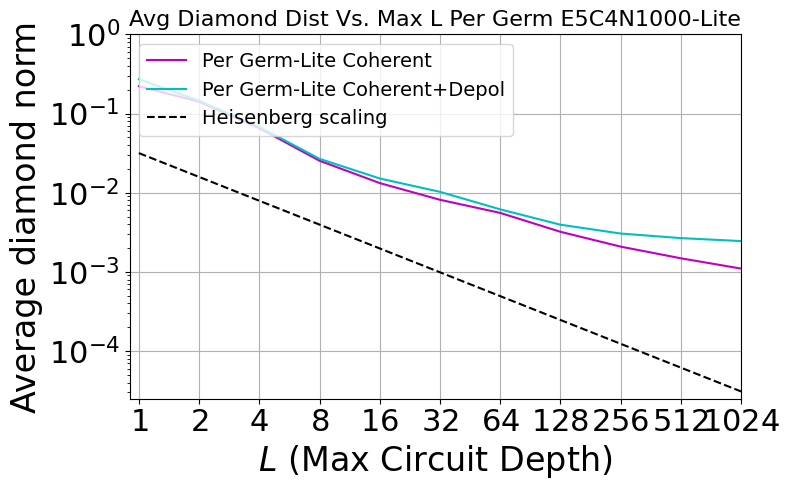

In [34]:
plot_ensemble_ddists([avg_gateset_ddists_pergermE5C2N1000_lite_TP_coher, avg_gateset_ddists_pergermE5C2N1000_lite_TP_incoher], [fl_shots, fl_shots], 
                     ['Per Germ-Lite Coherent', 'Per Germ-Lite Coherent+Depol'], [ 'm-', 'c-'], 'Avg Diamond Dist Vs. Max L Per Germ E5C4N1000-Lite', 'Average diamond norm',
                     './figure_output/avg_ddist_pergermE5C2N1000_lite_TP_coher_incoher.png', figure_size=(8,5))

### Lite GR and Per-Germ E5C2N20000 FPR Avg Diamond Distance Plot

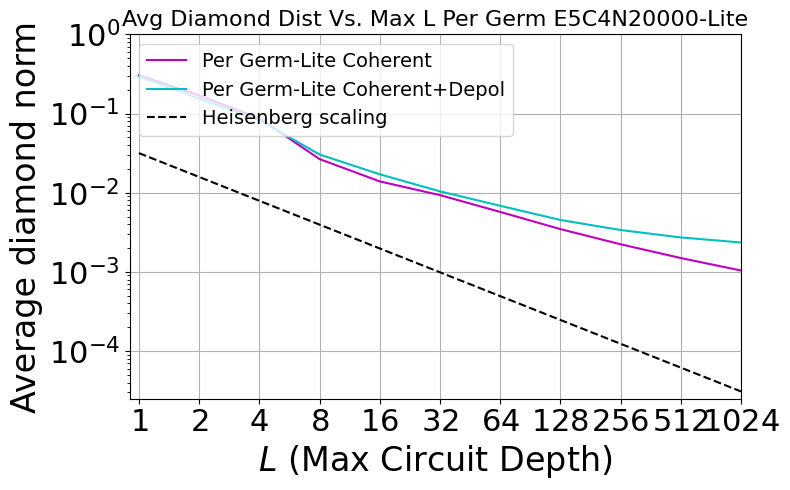

In [35]:
plot_ensemble_ddists([avg_gateset_ddists_pergermE5C2N20000_lite_TP_coher, avg_gateset_ddists_pergermE5C2N20000_lite_TP_incoher], [fl_shots, fl_shots], 
                     ['Per Germ-Lite Coherent', 'Per Germ-Lite Coherent+Depol'], [ 'm-', 'c-'], 'Avg Diamond Dist Vs. Max L Per Germ E5C4N20000-Lite', 'Average diamond norm',
                     './figure_output/avg_ddist_pergermE5C2N20000_lite_TP_coher_incoher.png', figure_size=(8,5))

### Lite GR and Per-Germ Power Random 50% FPR Avg Diamond Distance Plot

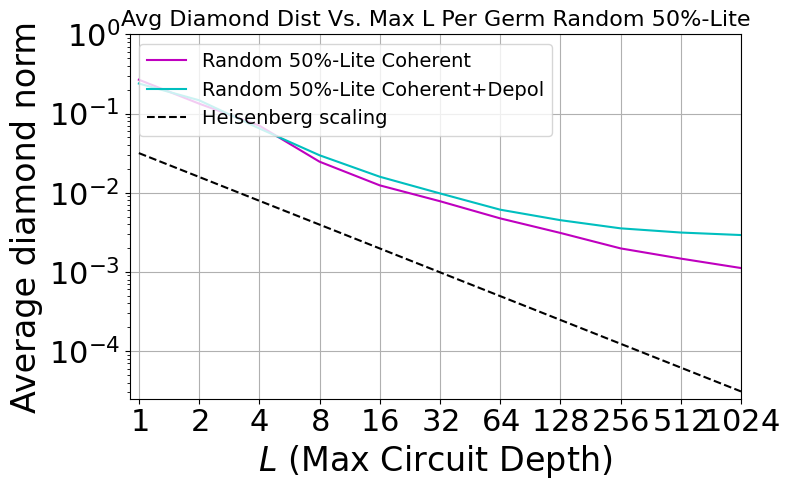

In [36]:
plot_ensemble_ddists([avg_gateset_ddists_pergermrand05_lite_TP_coher, avg_gateset_ddists_pergermrand05_lite_TP_incoher], [fl_shots, fl_shots], 
                     ['Random 50%-Lite Coherent', 'Random 50%-Lite Coherent+Depol'], [ 'm-', 'c-'], 'Avg Diamond Dist Vs. Max L Per Germ Random 50%-Lite', 'Average diamond norm',
                     './figure_output/avg_ddist_pergermrand05_lite_TP_coher_incoher.png', figure_size=(8,5))

### Lite GR and Per-Germ Power Random 25% FPR Avg Diamond Distance Plot

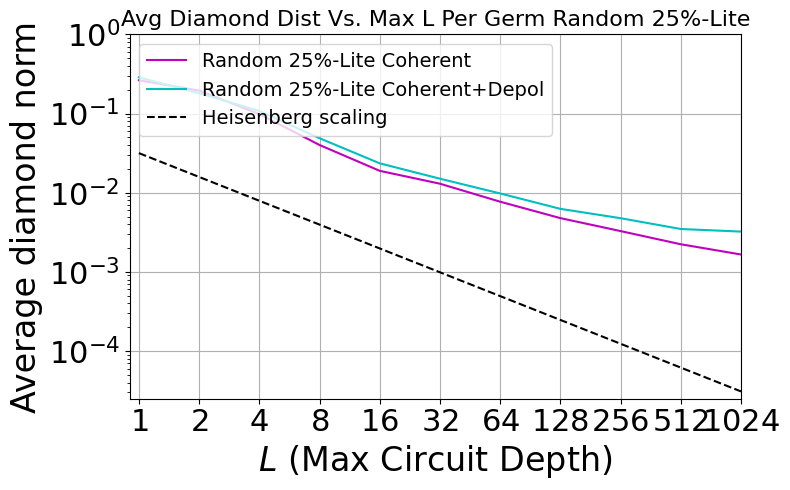

In [37]:
plot_ensemble_ddists([avg_gateset_ddists_pergermrand025_lite_TP_coher, avg_gateset_ddists_pergermrand025_lite_TP_incoher], [fl_shots, fl_shots], 
                     ['Random 25%-Lite Coherent', 'Random 25%-Lite Coherent+Depol'], [ 'm-', 'c-'], 'Avg Diamond Dist Vs. Max L Per Germ Random 25%-Lite', 'Average diamond norm',
                     './figure_output/avg_ddist_pergermrand025_lite_TP_coher_incoher.png', figure_size=(8,5))

### Lite GR and Per-Germ Power Random 12.5% FPR Avg Diamond Distance Plot

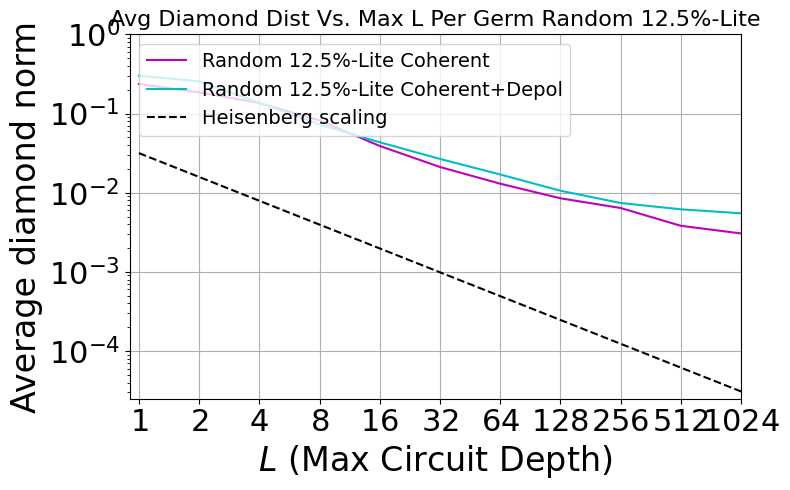

In [38]:
plot_ensemble_ddists([avg_gateset_ddists_pergermrand012_lite_TP_coher, avg_gateset_ddists_pergermrand012_lite_TP_incoher], [fl_shots, fl_shots], 
                     ['Random 12.5%-Lite Coherent', 'Random 12.5%-Lite Coherent+Depol'], [ 'm-', 'c-'], 'Avg Diamond Dist Vs. Max L Per Germ Random 12.5%-Lite', 'Average diamond norm',
                     './figure_output/avg_ddist_pergermrand012_lite_TP_coher_incoher.png', figure_size=(8,5))

### Lite GR and Per-Germ Power Random 9% FPR Avg Diamond Distance Plot

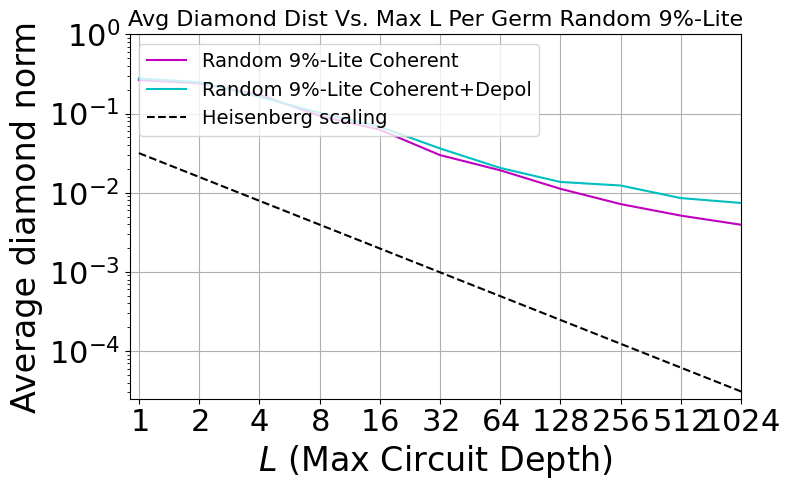

In [39]:
plot_ensemble_ddists([avg_gateset_ddists_pergermrand009_lite_TP_coher, avg_gateset_ddists_pergermrand009_lite_TP_incoher], [fl_shots, fl_shots], 
                     ['Random 9%-Lite Coherent', 'Random 9%-Lite Coherent+Depol'], [ 'm-', 'c-'], 'Avg Diamond Dist Vs. Max L Per Germ Random 9%-Lite', 'Average diamond norm',
                     './figure_output/avg_ddist_pergermrand009_lite_TP_coher_incoher.png', figure_size=(8,5))

### Lite GR and Per-Germ Power Random 6% FPR Avg Diamond Distance Plot

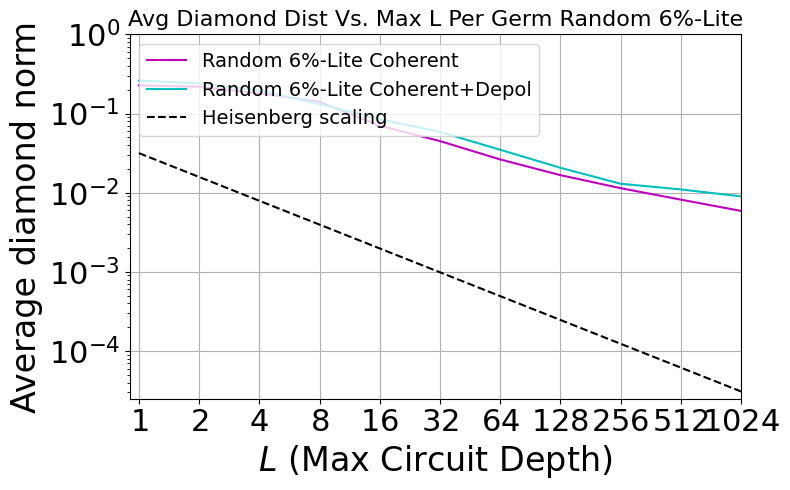

In [40]:
plot_ensemble_ddists([avg_gateset_ddists_pergermrand006_lite_TP_coher, avg_gateset_ddists_pergermrand006_lite_TP_incoher], [fl_shots, fl_shots], 
                     ['Random 6%-Lite Coherent', 'Random 6%-Lite Coherent+Depol'], [ 'm-', 'c-'], 'Avg Diamond Dist Vs. Max L Per Germ Random 6%-Lite', 'Average diamond norm',
                     './figure_output/avg_ddist_pergermrand006_lite_TP_coher_incoher.png', figure_size=(8,5))

### Lite GR and Per-Germ Power Random 3% FPR Avg Diamond Distance Plot

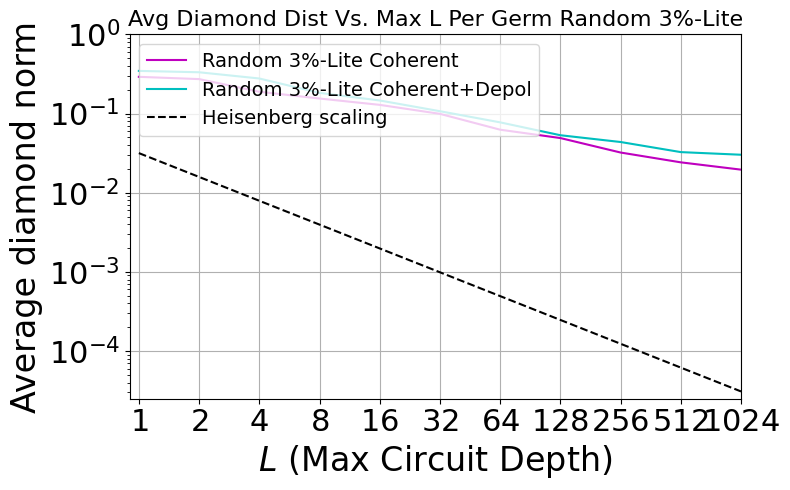

In [41]:
plot_ensemble_ddists([avg_gateset_ddists_pergermrand003_lite_TP_coher, avg_gateset_ddists_pergermrand003_lite_TP_incoher], [fl_shots, fl_shots], 
                     ['Random 3%-Lite Coherent', 'Random 3%-Lite Coherent+Depol'], [ 'm-', 'c-'], 'Avg Diamond Dist Vs. Max L Per Germ Random 3%-Lite', 'Average diamond norm',
                     './figure_output/avg_ddist_pergermrand003_lite_TP_coher_incoher.png', figure_size=(8,5))

## Plots Comparing different FPR Schemes on the Same Plot (Coherent-only)

In [42]:
#avg_gateset_ddists_full_lite_TP_coher[0].shape
avg_gateset_ddists_pergermE5C2N20000_lite_TP_coher[0].shape

(11,)

In [43]:
fl_shots.keys()

dict_keys([1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024])

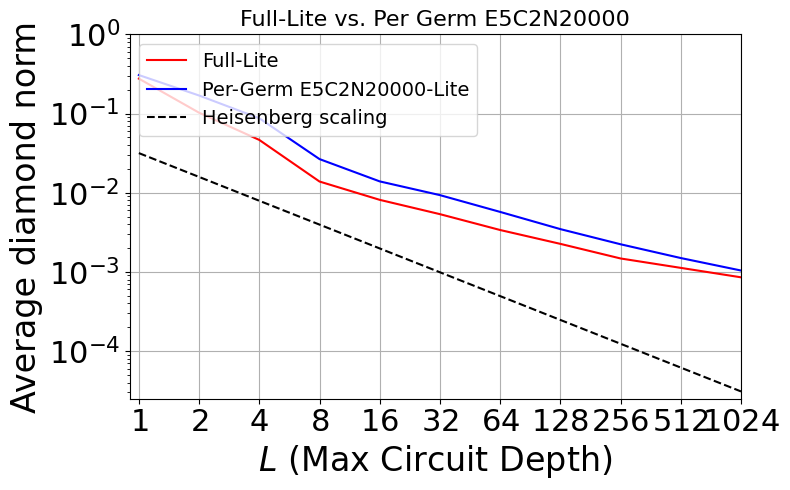

In [44]:
plot_ensemble_ddists([avg_gateset_ddists_full_lite_TP_coher, avg_gateset_ddists_pergermE5C2N20000_lite_TP_coher], [fl_shots, fl_shots], 
                     ['Full-Lite', 'Per-Germ E5C2N20000-Lite'], [ 'r-', 'b-'], 'Full-Lite vs. Per Germ E5C2N20000', 'Average diamond norm',
                     './figure_output/avg_ddist_fulllite_vs_pergermE5C2N20000_TP_coher.png', figure_size=(8,5))

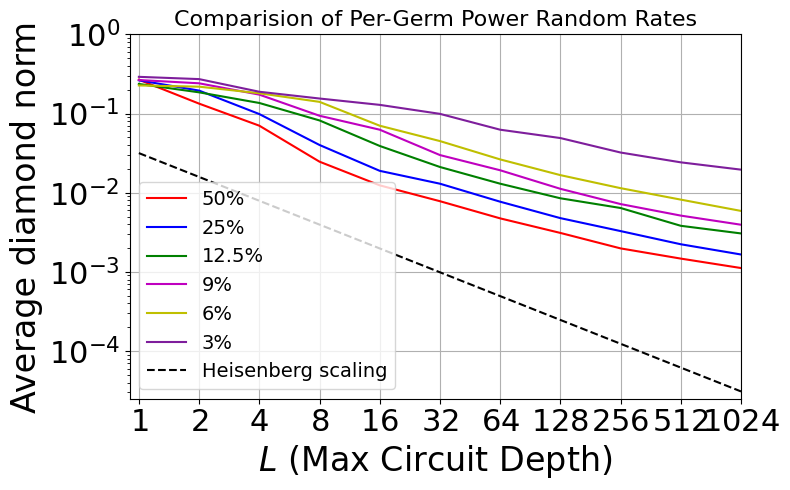

In [45]:
plot_ensemble_ddists([avg_gateset_ddists_pergermrand05_lite_TP_coher,  avg_gateset_ddists_pergermrand025_lite_TP_coher,
                      avg_gateset_ddists_pergermrand012_lite_TP_coher, avg_gateset_ddists_pergermrand009_lite_TP_coher, 
                      avg_gateset_ddists_pergermrand006_lite_TP_coher, avg_gateset_ddists_pergermrand003_lite_TP_coher], [fl_shots, fl_shots, fl_shots, fl_shots, fl_shots, fl_shots], 
                     ['50%','25%', '12.5%', '9%', '6%', '3%'], [ 'r-', 'b-', 'g-', 'm-', 'y-', 'xkcd:purple'], 'Comparision of Per-Germ Power Random Rates', 'Average diamond norm',
                     './figure_output/avg_ddist_pergermpowerrand_TP_coher.png', figure_size=(8,5), leg_loc= 'lower left')

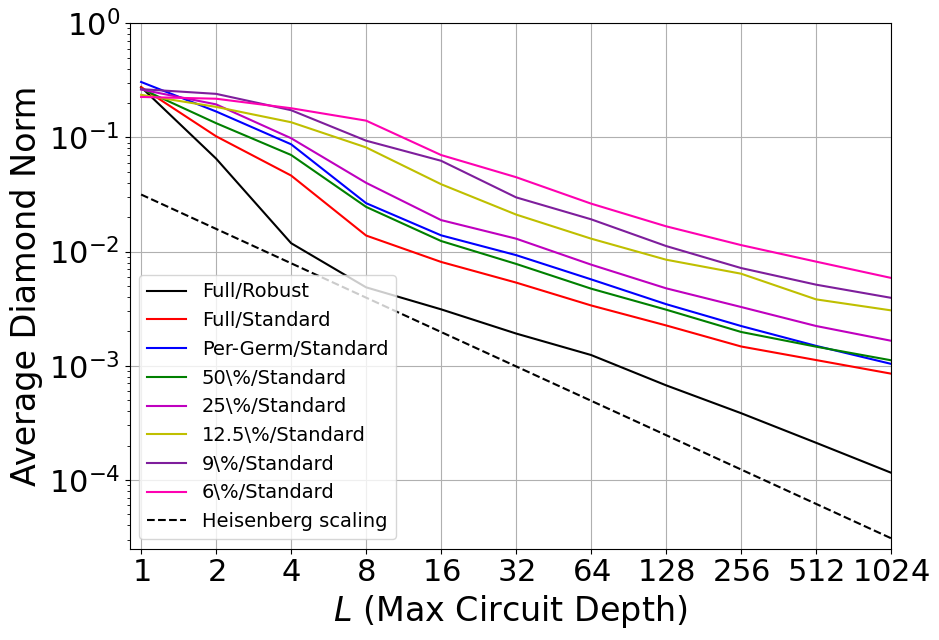

In [46]:
plot_ensemble_ddists([avg_gateset_ddists_full_full_TP_coher,
                      avg_gateset_ddists_full_lite_TP_coher, avg_gateset_ddists_pergermE5C2N20000_lite_TP_coher, 
                      avg_gateset_ddists_pergermrand05_lite_TP_coher, avg_gateset_ddists_pergermrand025_lite_TP_coher,
                      avg_gateset_ddists_pergermrand012_lite_TP_coher, avg_gateset_ddists_pergermrand009_lite_TP_coher, 
                      avg_gateset_ddists_pergermrand006_lite_TP_coher, avg_gateset_ddists_pergermrand003_lite_TP_coher], 
                     [fl_shots, fl_shots, fl_shots, fl_shots, fl_shots, fl_shots, fl_shots, fl_shots], 
                     ['Full/Robust', 'Full/Standard', 'Per-Germ/Standard','50\%/Standard',
                      '25\%/Standard', '12.5\%/Standard', '9\%/Standard', '6\%/Standard', '3\%/Standard'], 
                     ['k-','r-', 'b-', 'g-', 'm-', 'y-', 'xkcd:purple', 'xkcd:bright pink', 'xkcd:pumpkin'], '', r'Average Diamond Norm',
                     './figure_output/avg_ddist_everything_TP_coher.png', figure_size= (9.5,6.5), leg_loc= 'lower left', leg_fontsize=14)

# Plots for the Diamond Distance vs. Total Number of Circuits Comparing the different experiment designs

In [47]:
def plot_ddists_vs_num_circuits(ensemble_ddist_lists, L_dicts, labels, styles, title, ylabel, filename, figure_size=None, leg_loc=None, 
                                annotation1=None, annotation2=None, ncol=1, leg_fontsize=14, markersizes=None):
    
    
    #marker_list = ['o', 'v', '^', '<', '>' , 's', 'p', 'P', '*', 'D', 'X', 'h']
    
    if figure_size is not None:
        plt.figure(figsize=figure_size)
    
    for ensemble_ddists, L_dict, term_styles, term_labels, marker_size in zip(ensemble_ddist_lists, L_dicts, styles, labels, markersizes):
        lengths = list(L_dict.keys())
        eff_xs = list(L_dict.values())

        avgs = np.mean(ensemble_ddists, axis=0)
        stds = np.std(ensemble_ddists, axis=0)
        
        plt.errorbar(eff_xs, avgs, yerr=stds, fmt=term_styles, label=term_labels, markersize=marker_size, capsize=2)
    
    plt.plot(list(L_dicts[0].values()),len(lengths)*[0.003057], 'm--', linewidth=.5)
    
    axes = plt.gca()
    axes.set_xscale('log')
    axes.minorticks_off()
    axes.set_yscale('log')
    axes.set_ylim([1e-4, 1])

    plt.grid()
    #plt.legend(ncol=2, loc='lower left')
    
    if leg_loc is None:
        if ncol is None:
            plt.legend(loc='upper left', ncol=1, fontsize=leg_fontsize)
        else:
            plt.legend(loc='upper left', ncol=ncol, fontsize=leg_fontsize)
    else:
        if ncol is None:
            plt.legend(loc=leg_loc, ncol=1, fontsize=leg_fontsize)
        else:
            plt.legend(loc=leg_loc, ncol=ncol, fontsize=leg_fontsize)
        
    plt.title(title, fontsize=16)
    plt.xlabel('Number of Circuits', fontsize=24)
    plt.xlim([700, 1.1e5])
    plt.xticks(fontsize=22)
    plt.yticks(fontsize=22)
    plt.ylabel(ylabel, fontsize=24)
    
    plt.minorticks_on()
    
    if annotation1 is not None:
        plt.annotate(annotation1[0], annotation1[1], xytext= annotation1[2], arrowprops= annotation1[3], fontsize=18)
    
    if annotation2 is not None:
        plt.annotate(annotation2[0], annotation2[1], xytext= annotation2[2], arrowprops= annotation2[3], fontsize=18)
    
    plt.tight_layout()
    plt.savefig(filename, facecolor='white', dpi=128)
    plt.show()

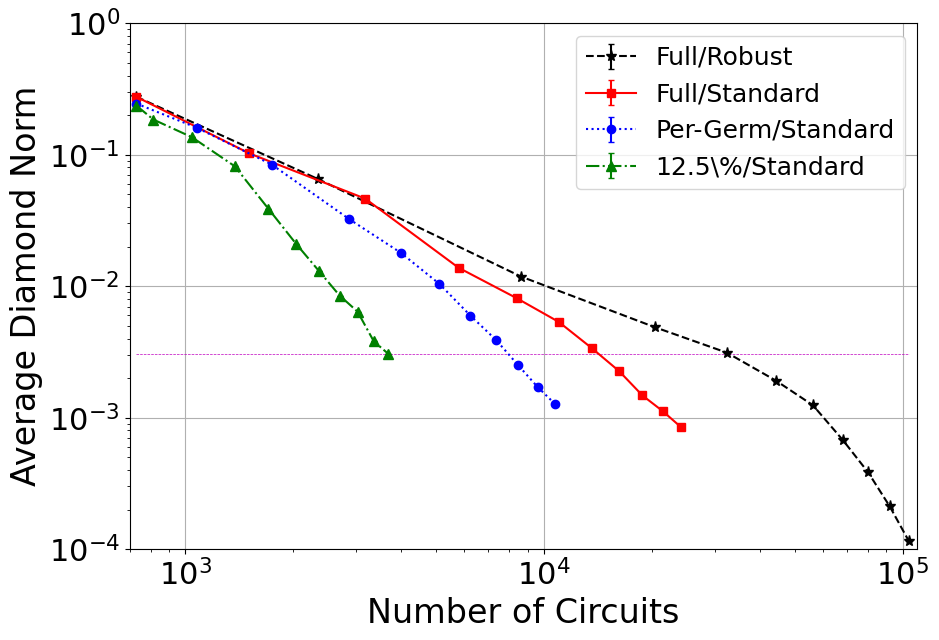

In [48]:
ff_shots = get_shot_counts_by_L(comb_edesign['Full','Full'], num_shots=1)
fl_shots = get_shot_counts_by_L(comb_edesign['Full','Lite'], num_shots=1)
pg_shots = get_shot_counts_by_L(comb_edesign['PerGermE0.033C30.00N20000', 'Lite'], num_shots=1)
pgr012_shots= get_shot_counts_by_L(comb_edesign['PerGermRand0.12-0', 'Lite'], num_shots=1)

plot_ddists_vs_num_circuits([avg_gateset_ddists_full_full_TP_coher, 
                             avg_gateset_ddists_full_lite_TP_coher,
                             avg_gateset_ddists_pergermE033C30N20000_lite_TP_coher, 
                             avg_gateset_ddists_pergermrand012_lite_TP_coher],
               [ff_shots, fl_shots, pg_shots, pgr012_shots],
               ['Full/Robust','Full/Standard','Per-Germ/Standard', '12.5\%/Standard'],
               ['k--*','r-s', 'b:o', 'g-.^'], '', 'Average Diamond Norm', './/ddists_vs_numckts_ddists_TP_coher.png', 
               figure_size=(9.5,6.5), markersizes=[8,6,6,7], leg_loc='upper right', leg_fontsize=18)

# Related analysis could be resource estimation, i.e., time to execute edesign on x-axis instead of number of circuits only
# (to take into account longer circuits at high L)

# Maybe even put LGST on this figure as a reference

In [49]:
print('Avg Gateset Diamond Dist Full-Full: ', avg_gateset_ddists_full_full_TP_coher[0])
print('Avg Gateset Diamond Dist Per-Germ Lite: ', avg_gateset_ddists_pergermE033C30N20000_lite_TP_coher[0])
print('Avg Gateset Diamond Dist Per-Germ Power Random 12.5% Lite: ', avg_gateset_ddists_pergermrand012_lite_TP_coher[0])
print('Avg Gateset Diamond Dist Full Lite: ', avg_gateset_ddists_full_lite_TP_coher[0])
print('Per-Germ- Lite Num Ckts by L: ', pg_shots)
print('Per-Germ-Power Random 12.5% Lite Num Ckts by L: ', pgr012_shots)
print('Full-Lite Num Ckts by L: ', fl_shots)
print('Full-Full Num Ckts by L: ', ff_shots)

Avg Gateset Diamond Dist Full-Full:  [2.756680e-01 6.521764e-02 1.185545e-02 4.866476e-03 3.122650e-03 1.916845e-03 1.243022e-03 6.745869e-04 3.846739e-04 2.117873e-04 1.157547e-04]
Avg Gateset Diamond Dist Per-Germ Lite:  [0.24474  0.160751 0.084255 0.032406 0.017986 0.010424 0.005989 0.003899 0.002504 0.001713 0.001276]
Avg Gateset Diamond Dist Per-Germ Power Random 12.5% Lite:  [0.236122 0.185139 0.135859 0.081758 0.038927 0.021114 0.012988 0.008498 0.006406 0.003817 0.003057]
Avg Gateset Diamond Dist Full Lite:  [0.275668 0.102341 0.046374 0.013833 0.008122 0.005356 0.003377 0.002258 0.001476 0.001123 0.000853]
Per-Germ- Lite Num Ckts by L:  {1: 731, 2: 1075, 4: 1742, 8: 2864, 16: 3987, 32: 5110, 64: 6233, 128: 7356, 256: 8479, 512: 9602, 1024: 10725}
Per-Germ-Power Random 12.5% Lite Num Ckts by L:  {1: 731, 2: 815, 4: 1044, 8: 1374, 16: 1704, 32: 2034, 64: 2363, 128: 2693, 256: 3023, 512: 3353, 1024: 3683}
Full-Lite Num Ckts by L:  {1: 731, 2: 1509, 4: 3175, 8: 5779, 16: 8388, 32:

## Two Qubit Fisher Information Plots

In [50]:
lengths= [1, 2, 4, 8, 16, 32, 64]

We'll plot two cases here, the full spectra and the full spectra minus the number of expected gauge parameters.

In [51]:
def plot_spectra_by_L_sym(fisher_spectra_by_L, Ls, filename, title, figure_size=None):
    
    #convert this spectra to a numpy array
    fisher_array= np.asarray(fisher_spectra_by_L)
    #this should have rows corresponding to the length and columns corresponding to the eigenvalues at that length in increasing order.
    #to get eigenvalue bands we should be able to just take the columns and plot those.
    
    if figure_size is not None:
        plt.figure(figsize=figure_size)
    
    for i in range(fisher_array.shape[1]):
        plt.plot(Ls, fisher_array[:,i])
        
    #also plot a line for the x axis.
    #plt.plot(Ls, [0]*len(Ls),'k')
    
    plt.xscale('log')
    plt.yscale('symlog')
    
    plt.xticks(Ls, Ls)
    
    #Addtional Formatting
    plt.title(title, fontsize=16)
    plt.xlabel(r'$L$, (maximum base circuit depth)', fontsize=16)
    plt.xlim([0.9, lengths[-1]])
    plt.ylabel('Eigenvalue', fontsize=16)

    plt.savefig(filename, facecolor='white', dpi=128)
    plt.show()

In [52]:
def plot_spectra_by_L(fisher_spectra_by_L, Ls, num_gauge, filename, title, figure_size=None):
    #In this version only plot the positive part of the spectra
    
    #convert this spectra to a numpy array
    fisher_array= np.asarray(fisher_spectra_by_L)
    #this should have rows corresponding to the length and columns corresponding to the eigenvalues at that length in increasing order.
    #to get eigenvalue bands we should be able to just take the columns and plot those.
    
    #count how many of the eigenvalues are negative:
    #num_negative= fisher_array[:,i]
    
    #drop the stated number of gauge parameters
    
    
    
    if figure_size is not None:
        plt.figure(figsize=figure_size)
    
    for i in range(num_gauge, fisher_array.shape[1]):
        plt.plot(Ls, fisher_array[:,i])

    #also plot a line for the x axis.
    plt.plot(Ls, [0]*len(Ls), 'k')
    
    
    plt.xscale('log')
    plt.yscale('log')
    
    plt.xticks(Ls, Ls)
    
    #Addtional Formatting
    plt.title(title, fontsize=16)
    plt.xlabel(r'$L$, (maximum base circuit depth)', fontsize=16)
    plt.xlim([0.9, lengths[-1]])
    plt.ylabel('Eigenvalue', fontsize=16)

    plt.savefig(filename, facecolor='white', dpi=128)
    plt.show()

In [53]:
def plot_spectra_by_L_violin(fisher_spectra_by_L, Ls, num_gauge, filename, title, figure_size=None):
    #In this version only plot the positive part of the spectra
    
    #convert this spectra to a numpy array
    fisher_array= np.asarray(fisher_spectra_by_L)
    #this should have rows corresponding to the length and columns corresponding to the eigenvalues at that length in increasing order.
    #to get eigenvalue bands we should be able to just take the columns and plot those.
    
    #count how many of the eigenvalues are negative:
    #num_negative= fisher_array[:,i]
    
    #drop the stated number of gauge parameters
    
    
    
    if figure_size is not None:
        plt.figure(figsize=figure_size)
    
    for i, spectra_at_L in enumerate(fisher_spectra_by_L):
        plt.boxplot(spectra_at_L[num_gauge:], positions=[i+1], showmeans=True, showfliers=False)

    #also plot a line for the x axis.
    #plt.plot(Ls, [0]*len(Ls), 'k')
    
    
    #plt.xscale('log')
    plt.yscale('log')
    
    plt.xticks(range(1,len(Ls)+1), Ls)
    
    #Addtional Formatting
    plt.title(title, fontsize=16)
    plt.xlabel(r'$L$, (maximum base circuit depth)', fontsize=16)
    #plt.xlim([0.9, lengths[-1]])
    plt.ylim([1e2, 1e13])
    plt.ylabel('Eigenvalue', fontsize=16)

    plt.savefig(filename, facecolor='white', dpi=128)
    plt.show()

In [54]:
#print(fisher_spectra_by_L_pergermpower_lite)

### Fisher Spectra With Gauge Dropped

In [55]:
#plot_spectra_by_L(fisher_spectra_by_L_full_full,lengths,num_gauge=12, filename='./figure_output/fisher_info_spectra_full_full.png', title='Fisher Information Eigenvalues vs L',
#                      figure_size=(8,10))

## Two-Qubit Fisher Information Matrices

Load in the information matrices for the two qubit experiment designs.

In [59]:
FIM_full_lite                 = np.load('../data/data_XYCPHASE_L64_Full_Lite/cumul_fim_Full_Lite.npz')
FIM_pergermE033C30N1000_lite  = np.load('../data/data_XYCPHASE_L64_Per_Germ_E033C30N1000_Lite/cumul_fim_PerGermE033C30N1000_Lite.npz')
FIM_pergermE033C30N20000_lite = np.load('../data/data_XYCPHASE_L64_Per_Germ_E033C30N20000_Lite/cumul_fim_PerGermE033C30N20000_Lite.npz')
FIM_pergermE25C4N1000_lite    = np.load('../data/data_XYCPHASE_L64_Per_Germ_E25C4N1000_Lite/cumul_fim_PerGermE25C4N1000_Lite.npz')
FIM_pergermE25C4N20000_lite   = np.load('../data/data_XYCPHASE_L64_Per_Germ_E25C4N20000_Lite/cumul_fim_PerGermE25C4N20000_Lite.npz')
#FIM_pergermE5C2N1000_lite    = np.load('../data/data_XYCPHASE_L64_Per_Germ_E5C2N1000_Lite/cumul_fim_PerGermE5C2N1000_Lite.npz')
FIM_pergermE5C2N20000_lite    = np.load('../data/data_XYCPHASE_L64_Per_Germ_E5C2N20000_Lite/cumul_fim_PerGermE5C2N20000_Lite.npz')
FIM_pergermrand05_lite        = np.load('../data/data_XYCPHASE_L64_Per_Germ_Rand_50_Lite/cumul_fim_PerGermRand0.50_Lite.npz')
FIM_pergermrand025_lite       = np.load('../data/data_XYCPHASE_L64_Per_Germ_Rand_25_Lite/cumul_fim_PerGermRand0.25_Lite.npz')
FIM_pergermrand012_lite       = np.load('../data/data_XYCPHASE_L64_Per_Germ_Rand_12_Lite/cumul_fim_PerGermRand0.12_Lite.npz')
FIM_pergermrand009_lite       = np.load('../data/data_XYCPHASE_L64_Per_Germ_Rand_09_Lite/cumul_fim_PerGermRand0.09_Lite.npz')
FIM_pergermrand006_lite       = np.load('../data/data_XYCPHASE_L64_Per_Germ_Rand_06_Lite/cumul_fim_PerGermRand0.06_Lite.npz')
FIM_pergermrand003_lite       = np.load('../data/data_XYCPHASE_L64_Per_Germ_Rand_03_Lite/cumul_fim_PerGermRand0.03_Lite.npz')

In [60]:
fisher_spectra_by_L_full_lite                = [ np.linalg.eigvalsh(fisher_at_L) for fisher_at_L in  FIM_full_lite.values()]
fisher_spectra_by_L_pergermE033C30N1000_lite = [ np.linalg.eigvalsh(fisher_at_L) for fisher_at_L in  FIM_pergermE033C30N1000_lite.values()]
fisher_spectra_by_L_pergermE033C30N20000_lite= [ np.linalg.eigvalsh(fisher_at_L) for fisher_at_L in  FIM_pergermE033C30N20000_lite.values()]
fisher_spectra_by_L_pergermE25C4N1000_lite   = [ np.linalg.eigvalsh(fisher_at_L) for fisher_at_L in  FIM_pergermE25C4N1000_lite.values()]
fisher_spectra_by_L_pergermE25C4N20000_lite  = [ np.linalg.eigvalsh(fisher_at_L) for fisher_at_L in  FIM_pergermE25C4N20000_lite.values()]
#fisher_spectra_by_L_pergermE5C2N1000_lite   = [ np.linalg.eigvalsh(fisher_at_L) for fisher_at_L in  #FIM_pergermE5C2N1000_lite.values()]
fisher_spectra_by_L_pergermE5C2N20000_lite   = [ np.linalg.eigvalsh(fisher_at_L) for fisher_at_L in  FIM_pergermE5C2N20000_lite.values()]
fisher_spectra_by_L_pergermrand05_lite       = [ np.linalg.eigvalsh(fisher_at_L) for fisher_at_L in  FIM_pergermrand05_lite.values()]
fisher_spectra_by_L_pergermrand025_lite      = [ np.linalg.eigvalsh(fisher_at_L) for fisher_at_L in  FIM_pergermrand025_lite.values()]
fisher_spectra_by_L_pergermrand012_lite      = [ np.linalg.eigvalsh(fisher_at_L) for fisher_at_L in  FIM_pergermrand012_lite.values()]
fisher_spectra_by_L_pergermrand009_lite      = [ np.linalg.eigvalsh(fisher_at_L) for fisher_at_L in  FIM_pergermrand009_lite.values()]
fisher_spectra_by_L_pergermrand006_lite      = [ np.linalg.eigvalsh(fisher_at_L) for fisher_at_L in  FIM_pergermrand006_lite.values()]
fisher_spectra_by_L_pergermrand003_lite      = [ np.linalg.eigvalsh(fisher_at_L) for fisher_at_L in  FIM_pergermrand003_lite.values()]

In [57]:
#list(FIM_full_lite.values())

### Full-Lite Fisher Info Spectra

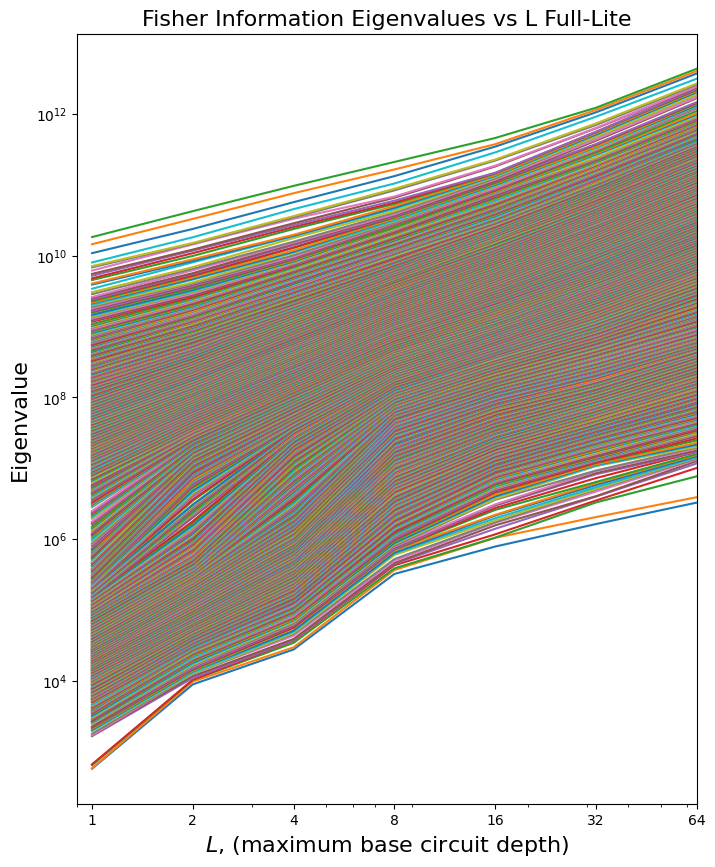

In [61]:
plot_spectra_by_L(fisher_spectra_by_L_full_lite,lengths,num_gauge=240, filename='./figure_output/fisher_info_spectra_full_lite.png', title='Fisher Information Eigenvalues vs L Full-Lite',
                      figure_size=(8,10))

In [62]:
len(fisher_spectra_by_L_full_lite[0])-240

1023

In [63]:
target_model1=smq2Q_XYCPHASE.target_model('full TP')
target_model1.num_gauge_params

240

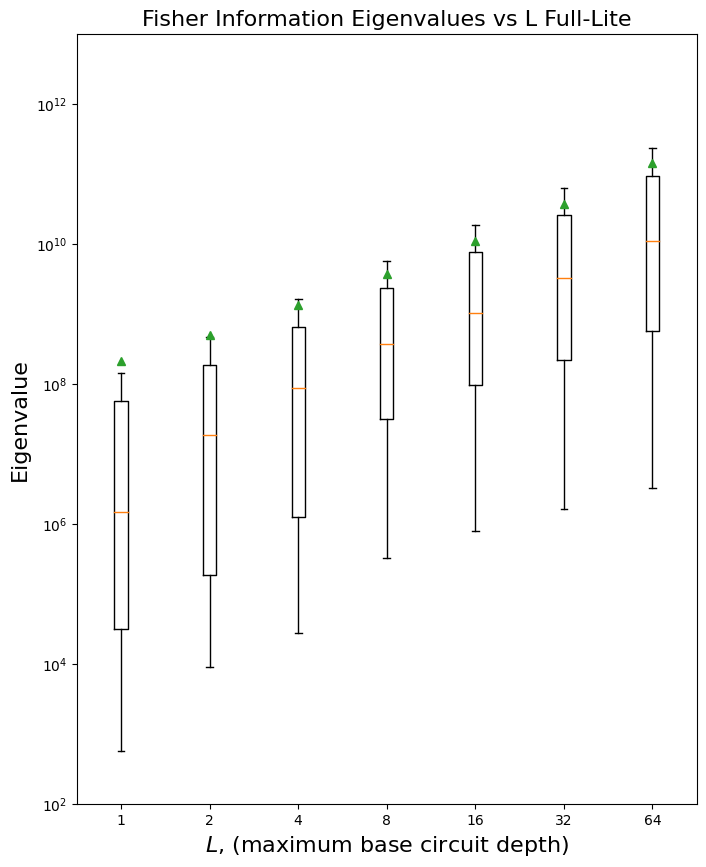

In [64]:
plot_spectra_by_L_violin(fisher_spectra_by_L_full_lite,lengths,num_gauge=240, filename='./figure_output/fisher_info_spectra_full_lite.png', title='Fisher Information Eigenvalues vs L Full-Lite',
                      figure_size=(8,10))

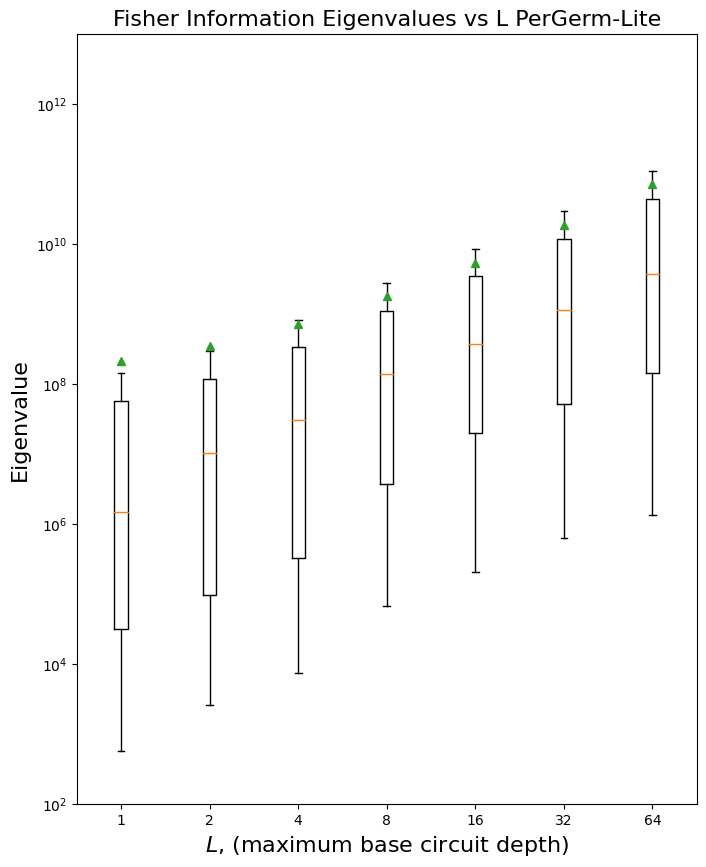

In [65]:
plot_spectra_by_L_violin(fisher_spectra_by_L_pergermE033C30N20000_lite,lengths,num_gauge=240, filename='./figure_output/fisher_info_spectra_pergermE033C30N20000_lite.png', title='Fisher Information Eigenvalues vs L PerGerm-Lite',
                      figure_size=(8,10))

In [66]:
np.linalg.norm(np.asarray(fisher_spectra_by_L_pergermE033C30N20000_lite)- np.asarray(fisher_spectra_by_L_full_lite))

7086345662710.5

In [67]:
fisher_spectra_by_L_pergermE033C30N20000_lite[1]

array([-1.327206e-06, -8.619472e-07, -7.180529e-07, ...,  1.610899e+10,  2.276185e+10,  2.841761e+10])

In [68]:
fisher_spectra_by_L_full_lite[1]

array([-1.169972e-05, -1.974274e-06, -1.646243e-06, ...,  2.373713e+10,  3.288857e+10,  4.230787e+10])

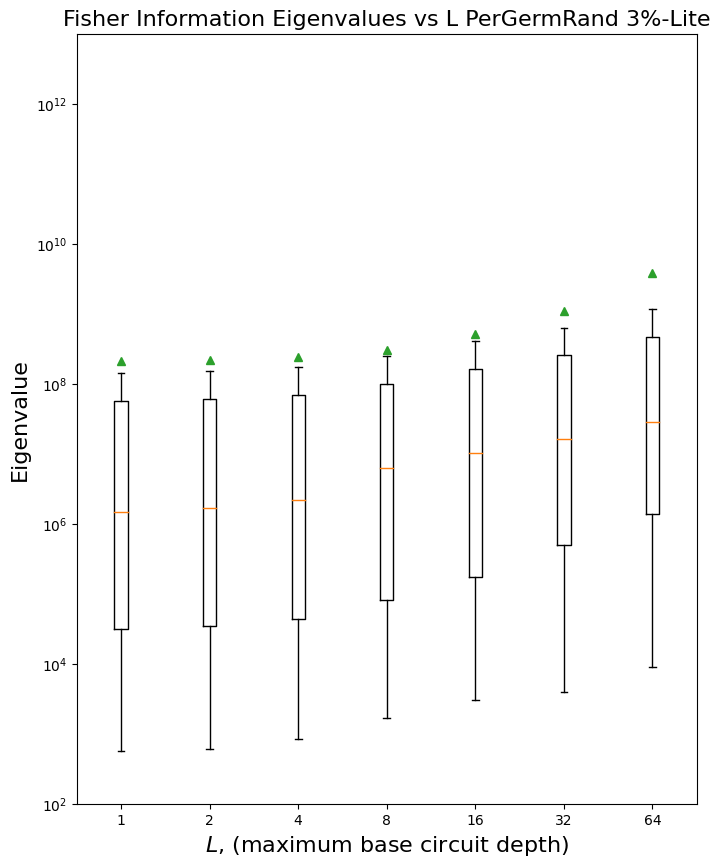

In [69]:
plot_spectra_by_L_violin(fisher_spectra_by_L_pergermrand003_lite,lengths,num_gauge=240, filename='./figure_output/fisher_info_spectra_pergermrand003_lite.png', title='Fisher Information Eigenvalues vs L PerGermRand 3%-Lite',
                      figure_size=(8,10))

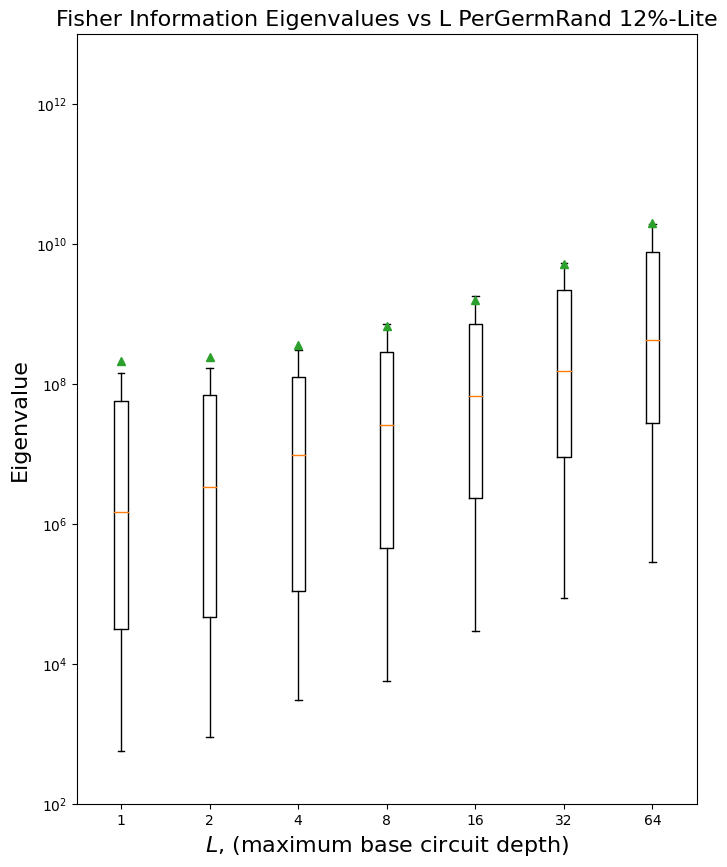

In [70]:
plot_spectra_by_L_violin(fisher_spectra_by_L_pergermrand012_lite,lengths,num_gauge=240, filename='./figure_output/fisher_info_spectra_pergermrand012_lite.png', title='Fisher Information Eigenvalues vs L PerGermRand 12%-Lite',
                      figure_size=(8,10))

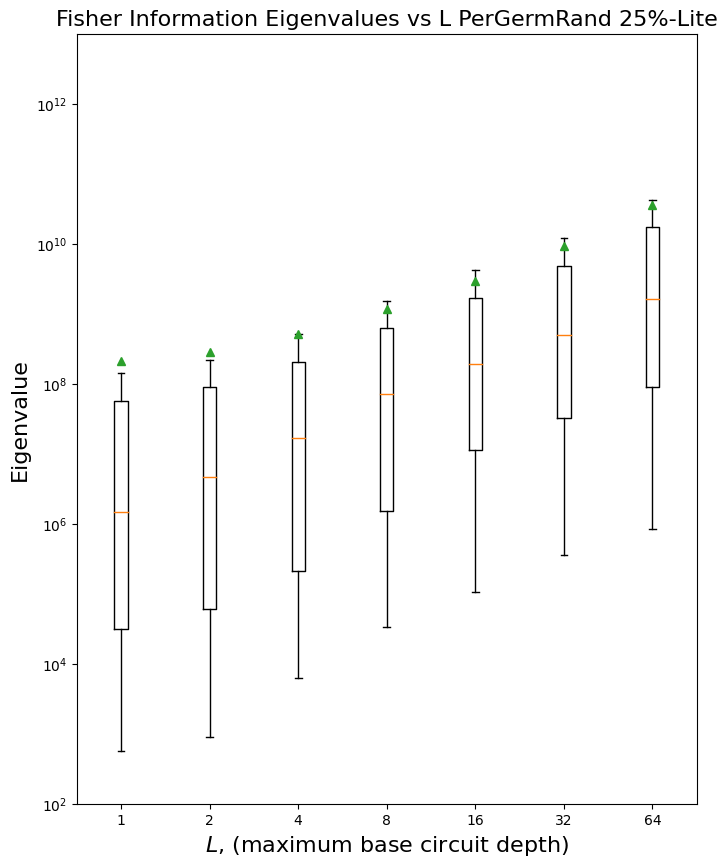

In [71]:
plot_spectra_by_L_violin(fisher_spectra_by_L_pergermrand025_lite,lengths,num_gauge=240, filename='./figure_output/fisher_info_spectra_pergermrand025_lite.png', 
                         title='Fisher Information Eigenvalues vs L PerGermRand 25%-Lite',
                      figure_size=(8,10))